In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt 
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline 


In [125]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [126]:
df.shape

(17176, 14)

In [127]:
df.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [178]:
print(df.shape[0] - df.dropna().shape[0])
print(df_test.shape[0] - df_test.dropna().shape[0])


#df = df.dropna()
#df_test = df_test.dropna()
df.fillna(df.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)


0
0


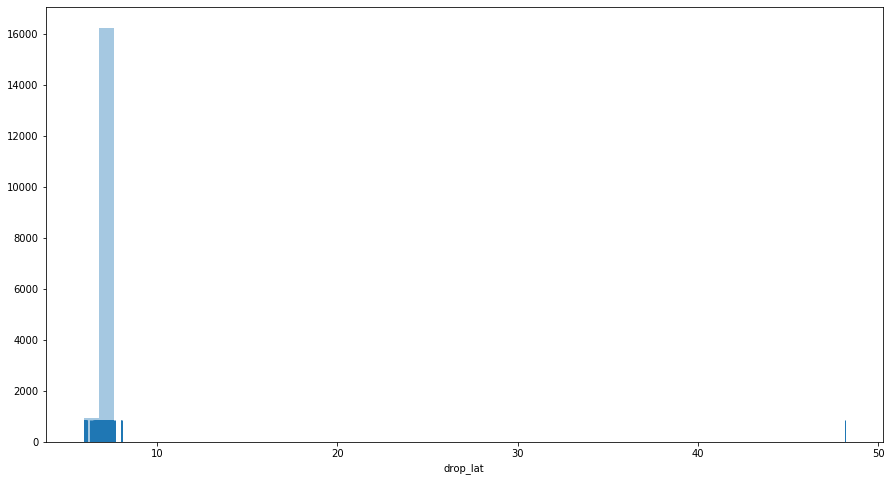

In [129]:
plt.figure(figsize = (15,8))
sn.distplot(df["drop_lat"], kde=False, rug=True)

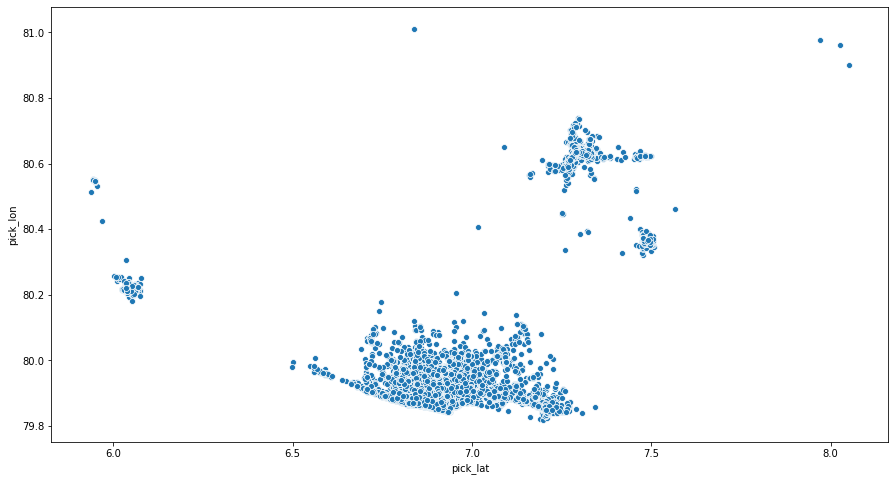

In [130]:
plt.figure(figsize = (15,8))
sn.scatterplot(df["pick_lat"], df["pick_lon"])

In [131]:
from sklearn.cluster import KMeans ,AgglomerativeClustering

# creates 4 clusters using k-means clustering algorithm.
kmeans_pickup = KMeans(4)
clusters = kmeans_pickup.fit_predict(df[['pick_lat','pick_lon']])
df['pickup_cluster'] = kmeans_pickup.predict(df[['pick_lat','pick_lon']])
df_test['pickup_cluster'] = kmeans_pickup.predict(df_test[['pick_lat','pick_lon']])

kmeans_drop = KMeans(4)
clusters = kmeans_drop.fit_predict(df[['drop_lat','drop_lon']])
df['drop_cluster'] = kmeans_drop.predict(df[['drop_lat','drop_lon']])
df_test['drop_cluster'] = kmeans_drop.predict(df_test[['drop_lat','drop_lon']])

In [132]:
df.tail()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pickup_cluster,drop_cluster
17171,213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct,2,0
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct,1,1
17173,213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct,3,1
17174,213815405,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31,correct,1,1
17175,213817296,10.5,262.0,21.0,1.2243,23.0,1/31/2020 23:49,1/31/2020 23:53,6.90257,79.9557,6.90823,79.9374,98.57,correct,1,1


In [133]:
def binarize_target(row):
    if row["label"]=="correct":
        return 1
    return 0

In [134]:
df['label'] = df.apply (lambda row: binarize_target(row), axis=1)
df_test['label'] = df.apply (lambda row: binarize_target(row), axis=1)


In [135]:
def get_distance(row):
    origin = (row["pick_lat"], row["pick_lon"])
    dist = (row["drop_lat"], row["drop_lon"])

    distance = geodesic(origin, dist).kilometers
    
    return distance

def haversine_distance(row):
    lat_p, lon_p = row['pick_lat'], row['pick_lon']
    lat_d, lon_d = row['drop_lat'], row['drop_lon']
    radius = 6371 # km

    dlat = np.radians(lat_d - lat_p)
    dlon = np.radians(lon_d - lon_p)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat_p)) * np.cos(np.radians(lat_d)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = radius * c

    return distance


In [136]:
df['distance'] = df.apply (lambda row: haversine_distance(row), axis=1)
df_test['distance'] = df_test.apply (lambda row: haversine_distance(row), axis=1)

df_test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_cluster,drop_cluster,label,distance
0,213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27,1,1,0,6.705702
1,213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70,1,1,0,41.558513
2,213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00,1,1,0,5.916678
3,213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32,1,1,0,3.301761
4,213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47,1,1,0,2.588542


In [137]:
df = df.drop('pick_lat', 1)
df = df.drop('pick_lon', 1)
df = df.drop('drop_lat', 1)
df = df.drop('drop_lon', 1)

df_test = df_test.drop('pick_lat', 1)
df_test = df_test.drop('pick_lon', 1)
df_test = df_test.drop('drop_lat', 1)
df_test = df_test.drop('drop_lon', 1)

df.tail()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,fare,label,pickup_cluster,drop_cluster,distance
17171,213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,198.26,1,2,0,2.105376
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,581.23,1,1,1,10.868377
17173,213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,76.20,1,3,1,1.045518
17174,213815405,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,133.31,1,1,1,2.879077
17175,213817296,10.5,262.0,21.0,1.2243,23.0,1/31/2020 23:49,1/31/2020 23:53,98.57,1,1,1,2.115875


In [138]:
def get_time_diff(date_1, date_2):
    d1 = datetime.strptime(date_1, "%m/%d/%Y %H:%M")
    d2 = datetime.strptime(date_2, "%m/%d/%Y %H:%M")
    return (d2 - d1).seconds

def add_ride_time_col(row):
    return get_time_diff(row["pickup_time"], row["drop_time"])

In [139]:
def get_time(date):
    t = datetime.strptime(date,  "%m/%d/%Y %H:%M").time()
    #return (t.hour * 60 + t.minute) * 60 + t.second
    return t

def get_date(date):
    t = datetime.strptime(date,  "%m/%d/%Y %H:%M")
    return t

def set_pickup_hours(row):
    return get_time(row["pickup_time"]).hour 

def set_drop_seconds(row):
    t = get_time(row["drop_time"])
    return t.hour * 60 + t.minute

def set_pickup_year(row):
    return get_date(row["pickup_time"]).year

def set_pickup_month(row):
    return get_date(row["pickup_time"]).month

def set_pickup_day(row):
    return get_date(row["pickup_time"]).weekday()

In [140]:
df["ride_time"] = df.apply (lambda row: add_ride_time_col(row), axis=1)
df_test["ride_time"] = df_test.apply (lambda row: add_ride_time_col(row), axis=1)

In [141]:
df["pick_hour"] = df.apply (lambda row: set_pickup_hours(row), axis=1)
df_test["pick_hour"] = df_test.apply (lambda row: set_pickup_hours(row), axis=1)

df["pick_day"] = df.apply (lambda row: set_pickup_day(row), axis=1)
df_test["pick_day"] = df_test.apply (lambda row: set_pickup_day(row), axis=1)

df["pick_year"] = df.apply (lambda row: set_pickup_year(row), axis=1)
df_test["pick_year"] = df_test.apply (lambda row: set_pickup_year(row), axis=1)

df["pick_month"] = df.apply (lambda row: set_pickup_month(row), axis=1)
df_test["pick_month"] = df_test.apply (lambda row: set_pickup_month(row), axis=1)

df["drop_seconds"] = df.apply (lambda row: set_drop_seconds(row), axis=1)
df_test["drop_seconds"] = df_test.apply (lambda row: set_drop_seconds(row), axis=1)

In [142]:
df.sample(100)

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,fare,label,pickup_cluster,drop_cluster,distance,ride_time,pick_hour,pick_day,pick_year,pick_month,drop_seconds
15676,211851014,10.5,864.0,164.0,9.501557,17.0,1/24/2020 11:44,1/24/2020 11:59,169.37,1,1,1,2.128151,900,11,4,2020,1,719
5035,195835182,10.5,3700.0,665.0,38.437000,2.0,11/29/2019 7:36,11/29/2019 8:38,711.49,1,1,1,14.569664,3720,7,4,2019,11,518
16249,212504332,10.5,3311.0,243.0,14.045400,168.0,1/27/2020 11:34,1/27/2020 12:29,725.06,1,1,1,6.816841,3300,11,0,2020,1,749
15744,211939812,5.0,466.0,152.0,8.861600,0.0,1/24/2020 16:57,1/24/2020 17:05,121.02,1,1,1,0.075483,480,16,4,2020,1,1025
16130,212355727,10.5,386.0,10.0,0.583000,59.0,1/26/2020 17:12,1/26/2020 17:18,96.70,1,3,1,0.603323,360,17,6,2020,1,1038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3412,193505030,10.5,667.0,51.0,0.000000,93.0,11/20/2019 20:01,11/20/2019 20:12,140.75,1,1,1,2.261214,660,20,2,2019,11,1212
39,189168508,10.5,558.0,77.0,0.115600,187.0,11/1/2019 9:43,11/1/2019 9:52,129.52,1,1,1,2.714383,540,9,4,2019,11,592
11192,205276497,10.5,2275.0,757.0,43.754600,11.0,12/30/2019 21:56,12/30/2019 22:33,410.91,1,1,1,5.751948,2220,21,0,2019,12,1353
4264,194728352,10.5,847.0,449.0,25.952200,65.0,11/25/2019 11:52,11/25/2019 12:06,132.77,1,3,1,1.182185,840,11,0,2019,11,726


In [143]:
df = df.drop('pickup_time', 1)
df = df.drop('drop_time', 1)
df = df.drop('ride_time', 1)
#df = df.drop('pick_seconds', 1)
df = df.drop('drop_seconds', 1)



df_test = df_test.drop('pickup_time', 1)
df_test = df_test.drop('drop_time', 1)
df_test = df_test.drop('ride_time', 1)
#df_test = df_test.drop('pick_seconds', 1)
df_test = df_test.drop('drop_seconds', 1)

df['duration'] = df['duration']/60
df_test['duration'] = df_test['duration']/60


df.tail()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,pickup_cluster,drop_cluster,distance,pick_hour,pick_day,pick_year,pick_month
17171,213803193,10.5,13.966667,93.0,5.4219,451.0,198.26,1,2,0,2.105376,22,4,2020,1
17172,213812756,10.5,35.850000,428.0,0.0000,39.0,581.23,1,1,1,10.868377,23,4,2020,1
17173,213813930,10.5,4.383333,9.0,0.0000,110.0,76.20,1,3,1,1.045518,23,4,2020,1
17174,213815405,10.5,14.300000,115.0,0.0000,317.0,133.31,1,1,1,2.879077,23,4,2020,1
17175,213817296,10.5,4.366667,21.0,1.2243,23.0,98.57,1,1,1,2.115875,23,4,2020,1


In [144]:
df_test.shape[0] - df_test.dropna().shape[0]

0

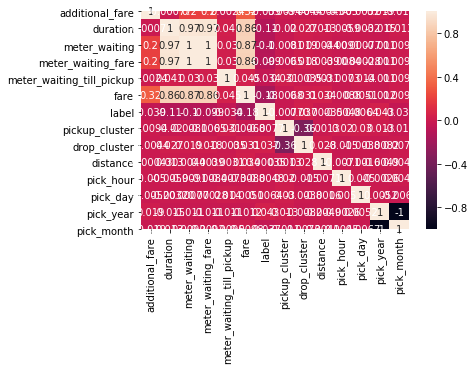

In [145]:
df_corr = df.drop('tripid', 1)

sn.heatmap(df_corr.corr(), annot=True)
plt.show()

In [146]:
print(df[df.label == 0].shape[0])
print(df[df.label == 1].shape[0])



1681
15495


In [232]:
X = df[[ 'additional_fare','duration','meter_waiting_till_pickup','fare','distance','pick_hour','pick_day','pick_year','pick_month']]
X_t = df_test[[ 'additional_fare','duration','meter_waiting_till_pickup','fare','distance','pick_hour','pick_day','pick_year','pick_month']]


#
from scipy import stats
X[(np.abs(stats.zscore(X)) < 3).all(axis=1)]

z_scores = stats.zscore(X)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
X = X[filtered_entries]
df = df[filtered_entries]

X_noramalized = preprocessing.scale(X)
X = pd.DataFrame(X_noramalized)

X_noramalized_t = preprocessing.scale(X_t)
X_t = pd.DataFrame(X_noramalized)

    
print(X.shape)

#from sklearn.preprocessing import PolynomialFeatures
#min_max_scaler = preprocessing.MinMaxScaler()
X_scaled=  preprocessing.normalize(X)
X_scaled_df = pd.DataFrame(X_scaled)

X_t_scaled=  preprocessing.normalize(X_t)
X_t_scaled_df = pd.DataFrame(X_t_scaled)




#trans = PolynomialFeatures(degree=1)
#poly = trans.fit_transform(X)
#poly_t = trans.fit_transform(X_t)

#X_poly = pd.DataFrame(poly)
#X_poly_t = pd.DataFrame(poly_t)

X_noramalized_df.head()




(11777, 9)


,0,1,2,3,4,5,6,7,8
0,-0.032119,-0.330397,-0.346615,0.412732,0.498118,-2.841505,0.535806,-0.704253,0.595405
1,-0.032119,-0.393660,0.646836,-0.170482,-0.195249,-2.841505,0.535806,-0.704253,0.595405
2,-0.032119,0.041827,-0.389191,0.664784,0.934960,-2.635070,0.535806,-0.704253,0.595405
3,-0.032119,-0.677610,-0.289846,-1.100388,-1.026013,-2.428634,0.535806,-0.704253,0.595405
4,-0.032119,0.275755,0.632644,0.382955,0.384589,-1.602892,0.535806,-0.704253,0.595405


In [233]:
Y = df['label'].values

In [234]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1000,stratify=Y)
#X_train,X_test,y_train,y_test = train_test_split(X_poly,Y,test_size=0.3,random_state=3, stratify=Y)


x = X_train.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_train = pd.DataFrame(x_scaled)

x = X_test.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_test = pd.DataFrame(x_scaled)

x_t = X_t.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_t_scaled = min_max_scaler.fit_transform(x_t)
X_t = pd.DataFrame(x_t_scaled)


In [235]:
oversample = RandomOverSampler(sampling_strategy=0.5, random_state=3)
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

print(X_train.shape)
print(X_train_resampled.shape)


undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=7)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train_resampled, y_train_resampled)






X_train_resampled.sample(10)

(8243, 9)
(11586, 9)


,0,1,2,3,4,5,6,7,8
4299,0.0,-0.820369,0.858472,-1.094348,-0.984351,0.048180,1.048065,1.419816,-1.415029
6110,0.0,-0.041437,1.631395,0.106426,-0.050092,-0.571724,-1.007228,1.419816,-1.415029
5894,0.0,-0.803955,0.572204,-0.926528,-1.191537,-0.158454,0.534242,-0.704317,0.595467
2172,0.0,-0.324957,1.201993,1.779144,-0.535562,0.254815,1.561889,-0.704317,0.595467
8317,0.0,1.185156,1.717276,0.040280,-0.869290,-0.984993,-1.521052,-0.704317,0.595467
10029,0.0,-0.415981,-1.016583,-0.748229,-0.260822,1.287988,1.048065,-0.704317,0.796516
9789,0.0,0.371904,-1.045210,0.287263,0.803066,1.081353,0.020419,-0.704317,0.595467
8660,0.0,-0.330925,-0.572868,-0.594244,-0.113710,0.461449,-0.493405,-0.704317,0.595467
7954,0.0,-1.047184,-1.188344,-0.970980,-0.702452,0.874719,1.561889,-0.704317,0.595467
3833,0.0,0.824042,-0.902076,1.399297,0.907948,-0.571724,-0.493405,-0.704317,0.796516


In [236]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train_resampled,y_train_resampled)
y_pred=logistic_regression.predict(X_test)


print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('F1: ',metrics.f1_score(y_test, y_pred))


Accuracy:  0.9366157328805885
F1:  0.966577141151895


print('Accuracy: ',metrics.accuracy_score(y_test, y_pred2))

Accuracy:  0.9575551782682513
F1:  0.9777249777249777
Confusion matrix, without normalization
[[  92  130]
 [  20 3292]]
Normalized confusion matrix
[[0.41 0.59]
 [0.01 0.99]]


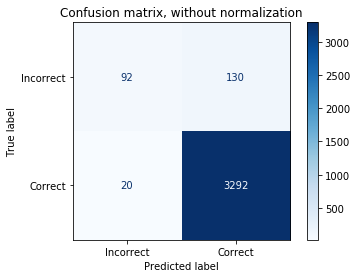

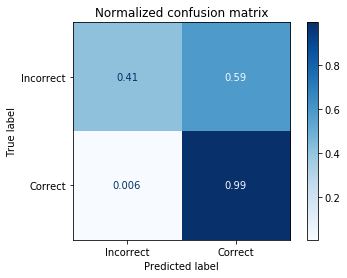

In [237]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
randomForest=RandomForestClassifier(n_estimators=100, n_jobs=-1)
randomForest.fit(X_train_resampled,y_train_resampled)
y_pred3=randomForest.predict(X_test)

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred3))
print('F1: ',metrics.f1_score(y_test, y_pred3))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(randomForest, X_test, y_test,
                                 display_labels=[ "Incorrect", "Correct"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()



Accuracy:  0.9077532541029995
F1:  0.9500765696784074
Confusion matrix, without normalization
[[ 106  116]
 [ 210 3102]]
Normalized confusion matrix
[[0.48 0.52]
 [0.06 0.94]]


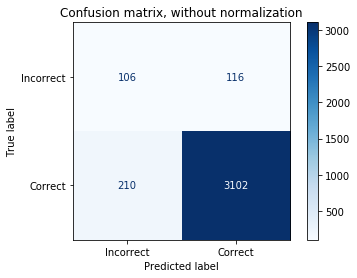

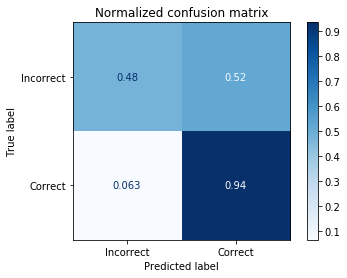

In [238]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train_resampled,y_train_resampled)
y_pred4=neigh.predict(X_test)

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred4))
print('F1: ',metrics.f1_score(y_test, y_pred4))

for title, normalize in titles_options:
    disp = plot_confusion_matrix(neigh, X_test, y_test,
                                 display_labels=[ "Incorrect", "Correct"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()



[21:26:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { class_weight, scoring } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.956140350877193
F1:  0.9768691240113415
Confusion matrix, without normalization
[[ 106  116]
 [  39 3273]]
Normalized confusion matrix
[[0.48 0.52]
 [0.01 0.99]]


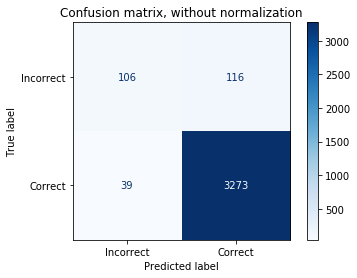

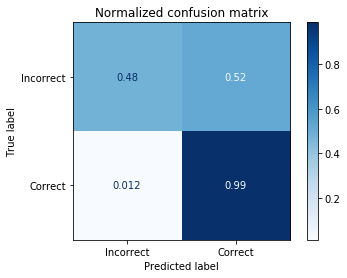

In [239]:
import xgboost as xgb

xgb_model=xgb.XGBClassifier(random_state=1,learning_rate=1, class_weight={0:10,1:1}, n_jobs=-1, scoring='roc_auc')
xgb_model.fit(X_train_resampled,y_train_resampled)
y_pred6 = xgb_model.predict(X_test)

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred6))
print('F1: ',metrics.f1_score(y_test, y_pred6))

for title, normalize in titles_options:
    disp = plot_confusion_matrix(xgb_model, X_test, y_test,
                                 display_labels=[ "Incorrect", "Correct"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [240]:

from keras import backend as K
from keras.layers import Dropout
from tensorflow.keras import initializers
from keras.regularizers import l2

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




model = Sequential()
model.add(Dense(
    256,
    input_dim=9,
    kernel_initializer=initializers.RandomNormal(stddev=0.02),
    #bias_initializer=initializers.Zeros(),
    activation='relu'))
model.add(Dense(
    256,
    kernel_initializer=initializers.RandomNormal(stddev=0.02),
    #bias_initializer=initializers.Zeros(),
    activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=120)

#model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=20)

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)

# evaluate the keras model
#_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))
print('f1_score: %.2f' % (f1_score*100))
print('precision: %.2f' % (precision*100))
print('recall: %.2f' % (recall*100))

Epoch 1/120
363/363 [==============================] - 1s 2ms/step - loss: 0.4105 - acc: 0.8327 - f1_m: 0.8857 - precision_m: 0.8176 - recall_m: 0.9742
Epoch 2/120
363/363 [==============================] - 1s 2ms/step - loss: 0.3210 - acc: 0.8735 - f1_m: 0.9084 - precision_m: 0.8648 - recall_m: 0.9613
Epoch 3/120
363/363 [==============================] - 1s 2ms/step - loss: 0.2973 - acc: 0.8843 - f1_m: 0.9162 - precision_m: 0.8751 - recall_m: 0.9655
Epoch 4/120
363/363 [==============================] - 1s 2ms/step - loss: 0.2879 - acc: 0.8884 - f1_m: 0.9184 - precision_m: 0.8814 - recall_m: 0.9629
Epoch 5/120
363/363 [==============================] - 1s 3ms/step - loss: 0.2767 - acc: 0.8878 - f1_m: 0.9157 - precision_m: 0.8791 - recall_m: 0.9595
Epoch 6/120
363/363 [==============================] - 1s 2ms/step - loss: 0.2703 - acc: 0.8924 - f1_m: 0.9181 - precision_m: 0.8817 - recall_m: 0.9613
Epoch 7/120
363/363 [==============================] - 1s 2ms/step - loss: 0.2607 - acc:

KeyboardInterrupt: 

In [241]:
pred=model.predict_classes(X_test)

preidction_list = []
for index in range(len(pred)):
    preidction_list.append(pred[index][0])
    
y_pred = np.array(preidction_list)
matrix = metrics.confusion_matrix(y_test, y_pred)
print(matrix)



[[ 123   99]
 [  98 3214]]


In [225]:
predictions=randomForest.predict(X_t)
print(predictions)




[0 0 0 ... 0 0 0]


In [183]:
print(df[df.label == 0].shape[0])
print(df[df.label == 1].shape[0])


1271
14462


In [226]:

prediction = pd.DataFrame(predictions, columns=['prediction'])
prediction['tripid'] = df_test["tripid"]
prediction.head()


,prediction,tripid
0,0,213284604
1,0,213286352
2,0,213293973
3,0,213294622
4,0,213298687


In [242]:
predictions=model.predict_classes(X_t)
#print(predictions)


prediction_tuples = []

for index in range(len(predictions)):
    #print(predictions[index][0])
    #print(df_test["tripid"][index])
    prediction_tuples.append(( df_test["tripid"][index], predictions[index][0]))


predictions_df = pd.DataFrame(prediction_tuples, columns = ['tripid','prediction'])

predictions_df.head()


KeyError: 8576

[[ 223   80]
 [ 172 3715]]


ValueError: plot_confusion_matrix only supports classifiers

In [228]:
prediction.to_csv('prediction.csv')